## Instal·lant dependències

In [ ]:
import os
from fastai import *
from fastai.text import *
from gensim.corpora import WikiCorpus

import numpy as np
import pandas as pd

from pathlib import Path
from functools import partial

In [ ]:
!pip install sacremoses

     |████████████████████████████████| 890kB 6.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=8d2f01e67e811af88ac648be384913e7ed04d25a9f8240769115f64da5ffc6f3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!nvidia-smi

Fri Aug 21 11:44:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    35W / 149W |     11MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Descarreguem el Wikipedia dump en català

In [ ]:
!rm -rf data/wiki_extr
!rm -rf wikiextractor/ WikiExtractor.py

In [ ]:
!sh get_wikimedia.sh

Saving data in data
Chosen language: ca
Starting download...
--2020-08-21 11:45:17--  https://dumps.wikimedia.org/cawiki/latest/cawiki-latest-pages-articles.xml.bz2
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.154.7, 2620:0:861:1:208:80:154:7
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.154.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 899327837 (858M) [application/octet-stream]
Saving to: 'data/wiki_dumps/cawiki-latest-pages-articles.xml.bz2'

cawiki-latest-pages 100%[===================>] 857.67M  4.86MB/s    in 2m 57s  

2020-08-21 11:48:14 (4.86 MB/s) - 'data/wiki_dumps/cawiki-latest-pages-articles.xml.bz2' saved [899327837/899327837]

Cloning into 'wikiextractor'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 661 (delta 0), reused 0 (delta 0), pack-reused 657
Receiving objects: 100% (661/661), 1.27 MiB | 2.92 MiB/s, don

In [ ]:
name = 'CatalanULMFit'
model_dir = 'models'
model_dir = Path(model_dir)
model_dir.mkdir(exist_ok=True)

Creem el corpus

In [ ]:
!ls data/wiki_extr/ca

AA  AB	AC  AD	AE  AF	AG  AH	AI  AJ	AK  AL	AM


In [ ]:
!python create_wikiText.py -i data/wiki_extr/ca -o data/wiki -l ca

Writing to data/wiki/ca-2/ca.wiki.train.tokens...
data/wiki/ca-2/ca.wiki.train.tokens. # documents: 6,499. # tokens: 2,000,114.
Copying data/wiki/ca-2/ca.wiki.train.tokens to data/wiki/ca-100/ca.wiki.train.tokens.
Writing to data/wiki/ca-2/ca.wiki.valid.tokens...
data/wiki/ca-2/ca.wiki.valid.tokens. # documents: 788. # tokens: 200,027.
Copying data/wiki/ca-2/ca.wiki.valid.tokens to data/wiki/ca-100/ca.wiki.valid.tokens.
Writing to data/wiki/ca-2/ca.wiki.test.tokens...
data/wiki/ca-2/ca.wiki.test.tokens. # documents: 640. # tokens: 200,178.
Copying data/wiki/ca-2/ca.wiki.test.tokens to data/wiki/ca-100/ca.wiki.test.tokens.
Writing to data/wiki/ca-100/ca.wiki.train.tokens...
Processed 10,000 documents. Total # tokens: 3,198,401.
Processed 30,000 documents. Total # tokens: 9,673,988.
Processed 40,000 documents. Total # tokens: 13,008,520.
Processed 50,000 documents. Total # tokens: 16,326,644.
Processed 60,000 documents. Total # tokens: 19,503,057.
Processed 90,000 documents. Total # toke

In [ ]:
 !python postprocess_wikiText.py -i data/wiki -l ca

Replacing numbers in data/wiki/ca-2/ca.wiki.train.tokens. Writing to data/wiki/ca-2/ca.wiki.train.tokens.unk.
Replacing numbers in data/wiki/ca-2/ca.wiki.valid.tokens. Writing to data/wiki/ca-2/ca.wiki.valid.tokens.unk.
Replacing numbers in data/wiki/ca-2/ca.wiki.test.tokens. Writing to data/wiki/ca-2/ca.wiki.test.tokens.unk.
Replacing numbers in data/wiki/ca-100/ca.wiki.train.tokens. Writing to data/wiki/ca-100/ca.wiki.train.tokens.unk.
Replacing numbers in data/wiki/ca-100/ca.wiki.valid.tokens. Writing to data/wiki/ca-100/ca.wiki.valid.tokens.unk.
Replacing numbers in data/wiki/ca-100/ca.wiki.test.tokens. Writing to data/wiki/ca-100/ca.wiki.test.tokens.unk.
OOV ratio: 0.0376.
ca-2 vocab size: 32420
OOV ratio: 0.0086.
ca-100 vocab size: 400161
Limiting vocab in data/wiki/ca-2/ca.wiki.train.tokens.unk. Writing to data/wiki/ca-2/ca.wiki.train.tokens.unk.
ca.wiki.train.tokens.unk. # of tokens: 2054248
Limiting vocab in data/wiki/ca-2/ca.wiki.valid.tokens.unk. Writing to data/wiki/ca-2/ca

In [ ]:
trn_path = Path('data/wiki/ca-2/ca.wiki.train.tokens')
val_path = Path('data/wiki/ca-2/ca.wiki.valid.tokens')

with open(trn_path, encoding='utf8') as f:
  train = f.readlines()

df_train = pd.DataFrame(
  {'content': train},
  columns=['content'])

df_train['is_valid'] = 0

with open(val_path, encoding='utf8') as f:
      val = f.readlines()

df_valid = pd.DataFrame(
  {'content': val},
  columns=['content'])

df_valid['is_valid'] = 1


df_regroup = pd.concat([df_train, df_valid])

In [ ]:
df_regroup.head()

,content,is_valid
0,Milledgeville ( Illinois )\n,0
1,\n,0
2,Milledgeville és una població dels Estats Unit...,0
3,\n,0
4,Demografia .\n,0


In [ ]:
df_regroup = df_regroup[df_regroup.content != '\n']
df_regroup.head()

,content,is_valid
0,Milledgeville ( Illinois )\n,0
2,Milledgeville és una població dels Estats Unit...,0
4,Demografia .\n,0
5,"Segons el cens del 2000 , Milledgeville tenia ...",0
7,"Dels 448 habitatges en un 27,5 % hi vivien nen...",0


In [ ]:
df_regroup.to_csv('data/wiki/full_train.csv', header=None, index=None)

In [ ]:
tokenizer = Tokenizer(lang='ca', n_cpus=6)
data_lm_full = (TextList.from_csv('data/wiki', csv_name='full_train.csv', cols=0, processor=[TokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(max_vocab=60000)])
           #Inputs: all the text files in path
            .split_from_df(col=1)
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=32))


In [ ]:
itos = data_lm_full.train_ds.vocab.itos
print('Size of vocabulary:', len(itos))
print('First 10 words in vocab:', ', '.join([itos[i] for i in range(10)]))

Size of vocabulary: 30656
First 10 words in vocab: xxunk, xxpad, xxbos, xxeos, xxfld, xxmaj, xxup, xxrep, xxwrep, de


In [ ]:
data_lm_full.save('full_lm_30k')

In [ ]:
torch.cuda.is_available()

True

# Entrenar el Language Model

Hem usat com a dataset tot el text que s'ha trobat en el repositori https://github.com/Softcatala/ca-text-corpus. També hem provat d'entrenar amb un dataset creat a partir del script **./get_wikimedia.sh** però ens tornava un dataset massa brut. 

In [ ]:
learn = language_model_learner(data_lm_full,  arch=AWD_LSTM, drop_mult=0, callback_fns=ShowGraph)

In [ ]:
# save vocabulary
print('Saving vocabulary...')
with open(os.path.join('data', 'itos.pkl'), 'wb') as f:
    pickle.dump(itos, f)

Saving vocabulary...


In [ ]:
data_lm_full.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,"km ² . \n xxbos xxmaj dels 448 habitatges en un 27,5 % hi vivien nens de menys de 18 anys , en un 55,6 % hi vivien parelles casades , en un 7,4 % dones solteres , i en un 34,6 % no eren unitats familiars . xxmaj en el 31,9 % dels habitatges hi vivien persones soles el 18,1 % de les quals corresponia a persones de"
1,"la seva xxmaj conferència , amb 106 punts . xxmaj després de guanyar en la fase final als xxmaj new xxmaj york xxmaj xxunk , els xxmaj montreal xxmaj canadiens i els xxmaj philadelphia xxmaj xxunk , els xxmaj tampa xxmaj bay xxmaj lightning es van proclamar campions de la xxmaj conferència xxmaj est i va aconseguir arribar per primera vegada en la seva història a la final de la"
2,"de les famílies i el 9,5 % de la població estaven per davall del llindar de pobresa . \n xxbos xxmaj poblacions properes . \n xxbos xxmaj el següent diagrama mostra les poblacions més properes . \n xxbos xxmaj simpson ( xxmaj illinois ) \n xxbos xxmaj simpson és una població dels xxmaj estats xxmaj units a l ' estat d ' xxmaj illinois . xxmaj"
3,"% entre 25 i 44 , un 18,9 % de 45 a 60 i un 9,8 % 65 anys o més . \n xxbos l ' edat mediana era de 32 anys . xxmaj per cada 100 dones de 18 o més anys hi havia 98,5 homes . \n xxbos xxmaj la renda mediana per habitatge era de xxunk $ i la renda mediana per família de xxunk"
4,"i el 12,3 % de la població estaven per davall del llindar de pobresa . \n xxbos xxmaj poblacions més properes . \n xxbos xxmaj el següent diagrama mostra les poblacions més properes . \n xxbos xxmaj crooksville \n xxbos xxmaj crooksville és una població dels xxmaj estats xxmaj units a l ' estat d ' xxmaj ohio . xxmaj segons el cens del 2000 tenia"


In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


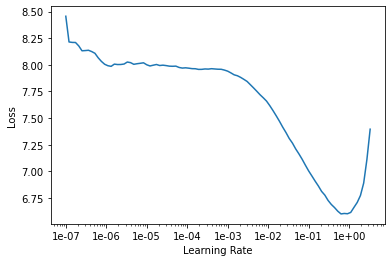

In [ ]:
learn.recorder.plot(skip_start=0)

epoch,train_loss,valid_loss,accuracy,time
0,3.251645,3.121398,0.464436,06:11
1,3.198326,3.160502,0.464463,06:12
2,3.011875,3.129758,0.465249,06:11
3,2.760864,3.074570,0.470408,06:11
4,2.441473,3.031145,0.472679,06:12
5,2.088003,3.039873,0.474470,06:12
6,1.830366,3.079516,0.471844,06:12


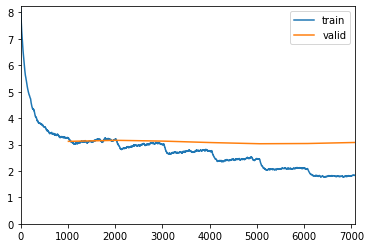

In [ ]:
learn.fit_one_cycle(7, 3e-2, moms=(0.8, 0.7))

In [ ]:
learn.save('model_60k-vocab-2')

In [ ]:
np.exp(3.07)

21.54190267500241